In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. 필요한 라이브러리와 app 데이터 세트 로딩

In [ ]:
import numpy as np
import pandas as pd
import gc
import time

%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [ ]:
## 필요한 train데이터와 test데이터 읽기

app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

## 2. Application_train에 대한 EDA 진행

In [ ]:
## app_train의 전체 컬럼 개수는 122개 이며, 이 중에서 결측치가 있는 컬럼 개수는 67개 

print(app_train.isnull().sum())
print("결측치 있는 컴럼 개수: ",sum(app_train.isnull().sum()!=0))

In [ ]:
## app_train의 전체 TARGET값 분포 확인
## TARGET=0인 값이 TARGET=1인 값보다 약 10배 정도 많음을 확인할 수 있다. 
## 0 : 대출금 상환 가능
## 1 : 대출금 상환 늦음

app_train['TARGET'].value_counts()

In [ ]:
## plot을 이용한 TARGET값 분포 시각화

app_train['TARGET'].astype(int).value_counts().plot(kind='bar');

## 3. Feature에 대해 TATGET값 분포 비교 및 시각화

In [ ]:
## feature별 target값에 대한 분포를 나타내는 히스토그램 시각화 함수
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=ax[0][0])
        sns.distplot(df[cond_1][column], label='1', color='red', ax=ax[0][1])
        sns.distplot(df[cond_0][column], label='0', color='blue', ax=ax[0][1])

In [ ]:
## Feature Importances 에서 중요하게 나왔던 칼럼만 가져옴

## AMT_ANNUITY는 TARGET=1시 상대적으로 작은 숫자대의 값이 조금 많다.
## DAYS_BIRTH는 TARGET=1시 적은 연령대의 숫자값이 상대적으로 많다.
## DAYS_EMPLOYED는 TARGET=1시 작은 값들이 조금 더 많다.
## 나머지 컬럼모두 큰 차이가 없음.

columns = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
           'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 
           'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
           'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

show_hist_by_target(app_train, columns)

In [ ]:
## category 피처(object 컬럼)을 TARGET 유형에 따라 Count 비교

object_columns = app_train.dtypes[app_train.dtypes == 'object'].index.tolist()
object_columns

In [ ]:
## catplot을 이용하면 타겟별로 분포를 확인하기 유용하다.

def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col='TARGET', data=df, kind='count')
        chart.set_xticklabels(rotation=65)

show_category_by_target(app_train, object_columns)

In [ ]:
## 고객 나이 분포에 대한 히스토그램 시각화
## 20대, 70대 연령을 제외하고 나머지 연령대에서는 비슷한 분포를 보인다.
## 이상값 없이 종 모양 형태로 고르게 분포되어 있다. 

app_train['DAYS_BIRTH']=abs(app_train['DAYS_BIRTH'])
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH']/365, edgecolor='k',bins=25)
plt.title('Age of Client');
plt.xlabel('Age (years)');
plt.ylabel('Count');

In [ ]:
plt.figure(figsize=(10,8))

## 제때 대출을 상환하는 고객의 나이 plot (TARGET=0)
## 40대에서 높은 밀도를 보이는 것을 확인할 수 있다.
sns.kdeplot(app_train.loc[app_train['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')

## 제때 대출을 상환하지못하는 고객의 나이 plot (TARGET=1)
## 20-30대에서 높은 밀도를 보이는 것을 확인할 수 있다. 대출을 상환을 못할 가능성이 높다는 의미
sns.kdeplot(app_train.loc[app_train['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')

plt.xlabel('Age(years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

In [ ]:
## CODE_GENDER 컬럼의 target 값에 따른 분포를 살펴보았다. 남녀 성별에 따른 차이를 확인
## 대출 횟수 대비 연체 비율이 남성이 여성보다 높음을 검증
cond_1 = (app_train['TARGET'] == 1)
cond_0 = (app_train['TARGET'] == 0)

print('CODE_GENDER\n')
print(app_train['CODE_GENDER'].value_counts()/app_train.shape[0])
print('\n연체인 경우\n',app_train[cond_1]['CODE_GENDER'].value_counts()/app_train[cond_1].shape[0])
print('\n연체가 아닌 경우\n',app_train[cond_0]['CODE_GENDER'].value_counts()/app_train[cond_0].shape[0])

## 4. 주요 컬럼들의 TARGET과의 상관도 분석

In [ ]:
## 양의 상관관계와 음의 상관관계 높은 것 확인
## 'DAYS_BIRTH','DAYS_EMPLOYED','REGION_RATING_CLIENT_W_CITY'가 양의 상관관계를 보이는 것들 중에 가장 높았다.

corr = app_train.corr()['TARGET'].sort_values()

print('양의 상관관계 상위10개:\n', corr.tail(10))
print('\n음의 상관관계 상위10개:\n', corr.head(10))

In [ ]:
## 상관관계가 높았던 columns과 관련있을 것으로 추정되는 columns과 TARGET간의 상관계수확인
corr_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','AMT_GOODS_PRICE','REGION_RATING_CLIENT_W_CITY',
               'DAYS_EMPLOYED','DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT', 'AMT_INCOME_TOTAL', 'TARGET']

col_corr = app_train[corr_columns].corr()
col_corr

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(col_corr, annot=True)

## 4-1. EXT_SORCE_X 변수들과 TARGET 값의 관계 확인 및 가공

In [ ]:
## 음의 상관이 가장 높았던 3개의 변수 EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3
## TARGET 변수와 EXT_SOURCE와의 상관관계와 EXT_SOURCE 서로간의 상관관계를 살핌

ext_data=app_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
ext_data_corrs=ext_data.corr()
ext_data_corrs

In [ ]:
## EXT_SOURCE_1과 DAYS_BIRTH가 0.600610으로 가장 높은 상관관계를 보인다.

plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

In [ ]:
## # 각 EXT_SOURCE 를 TARGET값 별로 나눠서 분포를 살핌

plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    
    sns.kdeplot(app_train.loc[app_train['TARGET']==0,source],label='target==0')
    sns.kdeplot(app_train.loc[app_train['TARGET']==1,source],label='target==1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' %source);
    plt.ylabel('Density');
plt.tight_layout(h_pad=2.5)


## EXT_SOURCE_2 와 EXT_SOURCE_3은 Target값에 따라서 변화가 존재한다는 것을 확인할 수 있다

## 5. Feature Engineering

In [ ]:
## 이상치 데이터 확인 DAYS_EMPLOYED 이상치 값 변경

app_train['DAYS_EMPLOYED'].value_counts()

In [ ]:
## 이상치 값인 365243을 NaN값으로 변경

app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace(365243, np.nan)
app_train['DAYS_EMPLOYED'].value_counts(dropna=False)

In [ ]:
## CODE_GENDER 컬럼에 이상치 값인 XNA값이 4개 존재한다는 것을 확인

app_train['CODE_GENDER'].value_counts()

In [ ]:
## 데이터 가공 전 학습과 테스트용 데이터 세트 결합
apps = pd.concat([app_train, app_test])
print(apps.shape)

In [ ]:
## EXT_SOURCE_X FEATURE 가공

apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
## 컬럼 방향으로 평균을 구하기 위해서 axis=1 추가 해야함

In [ ]:
## max, min 도 해볼 수 있지만, 상관관계가 높은 것에 대해 너무 가공하면 성능이 오히려 떨어질 수 있으므로 mean과 std 만 구한다

apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

In [ ]:
## 컬럼 중 NaN값이 하나라도 있는 경우 STD를 계산한 APPS_EXT_SOURCE_STD 컬럼 값도 NaN이다.

apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APPS_EXT_SOURCE_STD']].head(10)

In [ ]:
## apps['APPS_EXT_SOURCE_STD'] 의 NA값을 평균값(0.151008)으로 대체하여 채워넣는다.

apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())

In [ ]:
apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APPS_EXT_SOURCE_STD']].head(10)

In [ ]:
## AMT_CREDIT 비율로 Feature 가공

apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
apps['APPS_CREDIT_GOODS_DIFF'] = apps['AMT_CREDIT'] - apps['AMT_GOODS_PRICE']

In [ ]:
## AMT_INCOME_TOTAL 비율로 Feature 가공

## AMT_INCOME_TOTAL 비율로 대출 금액 관련 피처 가공
apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']

## 가족수를 고려한 가처분 소득 피처 가공. 
apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']


In [ ]:
## DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공

## DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득/자산 관련 Feature 가공. 
apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']

In [ ]:
## 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음.

object_columns = apps.dtypes[apps.dtypes=='object'].index.tolist()

for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

In [ ]:
## 학습 데이터와 테스트 데이터 다시 분리

apps_train = apps[-apps['TARGET'].isnull()]
apps_test = apps[apps['TARGET'].isnull()]
apps.shape, apps_train.shape, apps_test.shape

## 6. 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행.

In [ ]:
from sklearn.model_selection import train_test_split

ftr_app = apps_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = app_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape


In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

In [ ]:
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 100)

In [ ]:
## plot_importance라이브러릴 통해서 Feature Importances 확인
## APPS_ANNUITY_CREDIT_RATIO가 가장 높은 중요로들 보이고 있음을 확인할 수 있다.

from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

In [ ]:
## 학습된 Classifier를 이용하여 테스트 데이터 예측

preds = clf.predict_proba(apps_test.drop(['SK_ID_CURR', 'TARGET'], axis=1))[:, 1 ]

In [ ]:
app_test['TARGET'] = preds
app_test[['SK_ID_CURR', 'TARGET']].to_csv('apps_baseline_02.csv', index=False)

## submit 결과
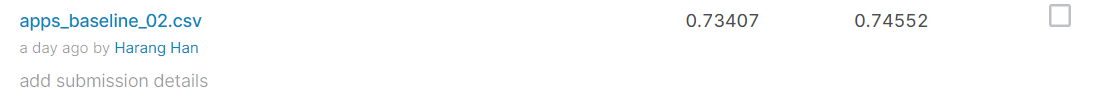

## 7. prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가

-> PREVIOUS_APPLICATION.CSV - 과거 대출 이력 (고객의 현재 대출 이전 과거 대출 정보 제공)

In [ ]:
## 이전 application 데이터의 feature engineering 부분을 함수로 만들어 복사
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [ ]:
## previous 데이터 로딩

prev = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
print(prev.shape, apps.shape)

In [ ]:
prev.head()

In [ ]:
## 주요 컬럼인 SK_ID_CURR EDA
## SK_ID_CURR당 평균 SK_ID_PREV 건수 구하기

prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()

In [ ]:
## 평균값이 4.928964135313716으로 0에서 20회 사이에 박스가 존재하며 이상치 값들이 많음을 확인할 수 있다.

sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count())

In [ ]:
# app_train[['SK_ID_CURR', 'TARGET']] 두가지 컬럼을 가지고 on='SK_ID_CURR' 조인

app_prev_target = prev.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev_target.shape

In [ ]:
# 숫자형 dtype 갖고 있는 컬럼만 추출
num_columns = app_prev_target.dtypes[app_prev_target.dtypes != 'object'].index.tolist()
num_columns

In [ ]:
## TARGET에 따라 숫자형 피처들의 Histogram

show_hist_by_target(app_prev_target, num_columns)

In [ ]:
## Category dtype 갖고 있는 컬럼만 추출

object_columns = app_prev_target.dtypes[app_prev_target.dtypes=='object'].index.tolist()
object_columns

In [ ]:
## TARGET에 따라 Category 피처들의 Histogram

show_category_by_target(app_prev_target, object_columns)

In [ ]:
# 신청금액과 실제 대출액, 상품금액과의 차이 비율, 만기일 차이 비교, 이자율 계산등의 주요 컬럼 가공 생산. 

def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    # DAYS_XXX 피처의 365243(이상치) 을 NULL로 변환
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 기존 이자율 관련 컬럼인 RATE_INTEREST_PRIVILEGED의 경우 Null값이 많아서 새롭게 이자율에대한 컬럼 생
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev

In [ ]:
# 기존 컬럼및 위에서 가공된 신규 컬럼들에 대해서 SK_ID_CURR 레벨로 Aggregation 수행.  
def get_prev_amt_agg(prev):

    agg_dict = {
         # 기존 주요 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 신규 가공 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg

In [ ]:
# NAME_CONTRACT_STATUS의 SK_ID_CURR별 Approved, Refused의 건수 계산.  
def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    # NAME_CONTRACT_STATUS로 group을 만들어 Approved와 Refused의 값을 확인
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
    
    return prev_refused_appr_agg

In [ ]:
# 앞에서 구한 prev_amt_agg와 prev_refused_appr_agg를 조인하고 SK_ID_CURR별 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [ ]:
# apps와 previous 데이터 세트를 SK_ID_CURR레벨로 다양한 컬럼이 aggregation되어 있는 prev_agg 조인
# 가공된 최종 데이터 세트 생성
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

In [ ]:
# Label 인코딩 수행. 
def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

In [ ]:
# 학습 데이터와 테스트 데이터 세트 분리. 
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

In [ ]:
# 학습 수행. 
def train_apps_all(apps_all_train):
    # 학습 데이터를 검증 데이터로 분리
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=32,
            subsample=0.8,
            max_depth=12,
            silent=-1,
            verbose=-1
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

In [ ]:
def get_dataset():
    app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
    app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
    
    apps = pd.concat([app_train, app_test])
    prev = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
    return apps, prev

In [ ]:
apps, prev = get_dataset()
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
clf = train_apps_all(apps_all_train)

In [ ]:
## application 데이터 셋만 사용할때와 다른 Feature Importance 결과를 확인 할 수 있다.
## 하지만, 상위권에 존재하는 변수들은 순서는 다르지만 비슷하게 존재한다.

plot_importance(clf, figsize=(16, 32))

In [ ]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_03.csv', index=False)

## submit 결과
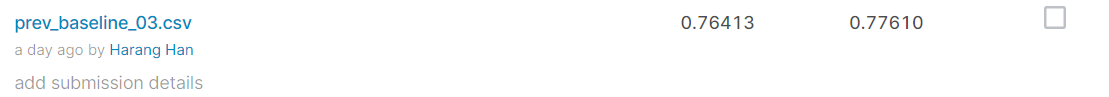

## 8. bureau와 bureau_bal 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가
->bureau.csv : 다른 금융 기관에서 제공 한 모든 고객의 이전 대출 정보

In [ ]:
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_bal = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')

In [ ]:
# TARGET 값을 가져오기 위해 bureau를 apps와 조인
bureau_app = bureau.merge(app_train[['SK_ID_CURR', 'TARGET']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
bureau_app.shape

In [ ]:
bureau_app['TARGET'].astype(int).value_counts().plot(kind='bar');

In [ ]:
## 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

num_columns = bureau_app.dtypes[bureau_app.dtypes != 'object'].index.tolist()
# 숫자형 컬럼중 ID와 TARGET은 제외
num_columns = [column for column in num_columns if column not in['SK_ID_BUREAU', 'SK_ID_CURR', 'TARGET']]
num_columns

In [ ]:
show_hist_by_target(bureau_app, num_columns)

In [ ]:
## Category 피처들의 Histogram을 TARGET 유형에 따라 비교

object_columns = bureau.dtypes[bureau.dtypes=='object'].index.tolist()
object_columns

In [ ]:
show_category_by_target(bureau_app, object_columns)

In [ ]:
# correlated features

corrmat = bureau_app.corr()
top_corr_features = corrmat.index[abs(corrmat["TARGET"])>=0.03]
plt.figure(figsize=(12,8))
g = sns.heatmap(bureau_app[top_corr_features].corr(),annot=True,cmap="Oranges")

In [ ]:
# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

In [ ]:
# bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성. 
def get_bureau_day_amt_agg(bureau):
        
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

In [ ]:
# Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
def get_bureau_active_agg(bureau):
    # CREDIT_ACTIVE='Active' 인 데이터만 filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_active_agg = bureau_active_agg.reset_index()
    print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

In [ ]:
# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg

In [ ]:
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    # 가공된 bureau관련 aggregation 컬럼들을 모두 조인하여 결합 후 return  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

In [ ]:
def get_apps_all_with_prev_bureau_agg(apps, prev, bureau, bureau_bal):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    print('prev_agg shape:', prev_agg.shape)
    print('bueau_agg shape:', bureau_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg, bureau_agg shape:', apps_all.shape)
    
    return apps_all

In [ ]:
# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합. 
apps_all = get_apps_all_with_prev_bureau_agg(apps, prev, bureau, bureau_bal)

In [ ]:
# Category 컬럼을 모두 Label 인코딩 수행 
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

In [ ]:
#학습수행

clf = train_apps_all(apps_all_train)

In [ ]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('bureau_baseline_04.csv', index=False)

## submit 결과
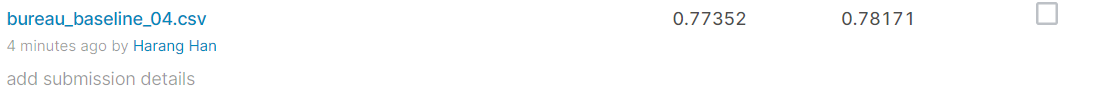

## - bureau, application, previous 데이터를 모두 사용했을 때 가장 좋은 성능을 보여준다.